<a href="https://colab.research.google.com/github/NBK-code/ImageClassification/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classifier for the SVHN dataset
 

In [7]:
import tensorflow as tf
from scipy.io import loadmat

#Further Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
import os
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In this project, we will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/) for image classification task. This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz).

In [1]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [2]:
! ls gdrive/MyDrive/Colab_Notebooks/Projects/Image_Classification/Data/

test_32x32.mat	train_32x32.mat


In [3]:
data_path = './gdrive/MyDrive/Colab_Notebooks/Projects/Image_Classification/Data/'

In [8]:
# Load the dataset from your Drive folder

train = loadmat(os.path.join(data_path, 'train_32x32.mat'))
test = loadmat(os.path.join(data_path, 'test_32x32.mat'))

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

In [9]:
#Extract training images and labels

train_images = train["X"]
train_labels = train["y"]

In [10]:
#Extract test images and labels

test_images = test["X"]
test_labels = test["y"]

In [11]:
#Print train data shape

print(train_images.shape)
print(train_labels.shape)
m_train,_ = train_labels.shape
print(m_train)

#Print test data shape

print(test_images.shape)
print(test_labels.shape)
m_test,_ = test_labels.shape
print(m_test)

(32, 32, 3, 73257)
(73257, 1)
73257
(32, 32, 3, 26032)
(26032, 1)
26032


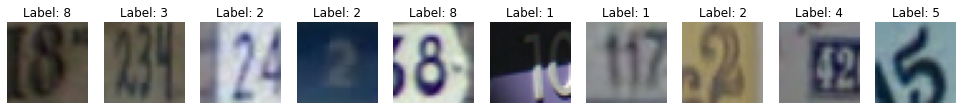

In [12]:
#Randomly sample 10 images from train data and display them with labels

seed_1 = random.sample(range(0,m_train), 10)
fig = plt.figure(figsize=(17, 17))
columns = 10
rows = 1
for i, idx in enumerate(seed_1):
    image = train_images[:,:,:,idx]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Label: {train_labels[idx,0]}')
plt.show()

In [13]:
#Convert train and test images into grayscale while retaining channel dimension

gs_train_images = np.reshape(np.average(train_images, axis=2),(32,32,1,m_train))
gs_test_images = np.reshape(np.average(test_images, axis=2),(32,32,1,m_test))

print(gs_train_images.shape)
print(gs_test_images.shape)

(32, 32, 1, 73257)
(32, 32, 1, 26032)


In [14]:
#Let us transpose the train and test images so that the first index refers to image number

gs_train_images = tf.transpose(gs_train_images, perm = [3,0,1,2])
gs_test_images = tf.transpose(gs_test_images, perm = [3,0,1,2])

print(gs_train_images.shape)
print(gs_test_images.shape)

(73257, 32, 32, 1)
(26032, 32, 32, 1)


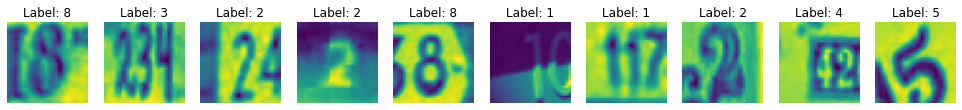

In [15]:
#Randomly sample 10 grayscale images from train data and display them with labels

fig = plt.figure(figsize=(17, 17))
columns = 10
rows = 1
for i, idx in enumerate(seed_1):
    image = gs_train_images[idx,:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Label: {train_labels[idx,0]}')
plt.show()

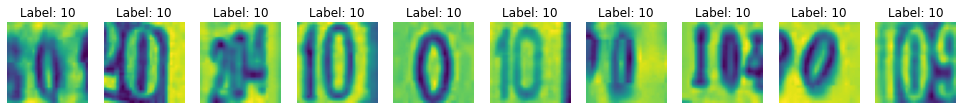

In [16]:
#Display images with label 10.
#Although the label is 10, the content of the image is actually 0.

s = []

for i in range(220):
    if train_labels[i,0] == 10:
        s.append(i)

fig = plt.figure(figsize=(17, 17))
columns = len(s)
rows = 1
for i, idx in enumerate(s):
    image = gs_train_images[idx,:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Label: {train_labels[idx,0]}')
plt.show()

In [17]:
#We change the all the train and test labels that are 10 to 0.
#We do this for two reason:
#    1) The images with labels 10 are really 'zero' images.
#    2) The softmax layer requires labels to be in range [0, c-1] where
#       c is the number of classes.
 
for i in range(m_train):
    if train_labels[i,0] == 10:
        train_labels[i,0] = 0
    
for i in range(m_test):
    if test_labels[i,0] == 10: 
        test_labels[i,0] = 0

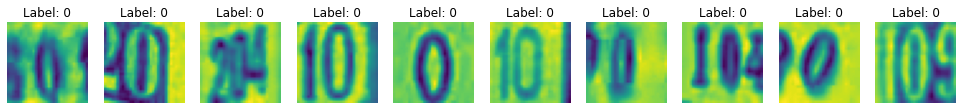

In [18]:
#Display images with label 0 (previously labeled as 10).

figr = plt.figure(figsize=(17, 17))
columns = len(s)
rows = 1
for i, idx in enumerate(s):
    image = gs_train_images[idx,:,:,0]
    figr.add_subplot(rows, columns, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Label: {train_labels[idx,0]}')
plt.show()

## 2. MLP neural network classifier

In [19]:
#Define MLP model

def get_new_MLP_model(input_shape):
    
    MLP_model = Sequential([
        Flatten(input_shape = input_shape),
        Dense(512, activation = "relu"),
        Dense(256, activation = "relu"),
        Dense(128, activation = "relu"),
        Dense(64, activation = "relu"),
        Dense(10, activation = "softmax")
    ])
    
    return MLP_model

In [20]:
MLP_model = get_new_MLP_model(gs_train_images[0].shape)

In [21]:
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 697,930
Trainable params: 697,930
Non-trainable params: 0
__________________________________________________

In [22]:
#Compile the model

MLP_model.compile(optimizer = "adam", 
                  loss = "sparse_categorical_crossentropy", 
                  metrics = ["accuracy"])

In [23]:
#Callback no 1

#Model Checkpoint Callback

checkpoint_best_only_path_MLP = "checkpoints_best_only_MLP/checkpoint"
checkpoint_best_only_MLP = ModelCheckpoint(filepath = checkpoint_best_only_path_MLP,
                                       save_weights_only = True, 
                                       monitor = "val_accuracy", 
                                       save_freq = "epoch", 
                                       save_best_only = True,
                                       verbose = 0)

In [24]:
#Callback no 2

#Early Stopping callback

early_stopping_MLP = EarlyStopping(monitor = "val_accuracy", 
                               patience=2, 
                               mode="max")

In [25]:
MLP_history = MLP_model.fit(gs_train_images, 
                            train_labels, 
                            epochs=30, 
                            validation_split=0.15, 
                            batch_size=64,
                            callbacks=[checkpoint_best_only_MLP, early_stopping_MLP])

Epoch 1/30
973/973 [==============================] - 7s 4ms/step - loss: 4.5725 - accuracy: 0.2203 - val_loss: 1.8402 - val_accuracy: 0.3711
Epoch 2/30
973/973 [==============================] - 4s 4ms/step - loss: 1.6608 - accuracy: 0.4535 - val_loss: 1.4701 - val_accuracy: 0.5042
Epoch 3/30
973/973 [==============================] - 4s 4ms/step - loss: 1.4083 - accuracy: 0.5485 - val_loss: 1.3621 - val_accuracy: 0.5553
Epoch 4/30
973/973 [==============================] - 4s 4ms/step - loss: 1.2912 - accuracy: 0.5910 - val_loss: 1.2711 - val_accuracy: 0.5956
Epoch 5/30
973/973 [==============================] - 4s 4ms/step - loss: 1.2155 - accuracy: 0.6182 - val_loss: 1.2368 - val_accuracy: 0.6176
Epoch 6/30
973/973 [==============================] - 4s 4ms/step - loss: 1.1420 - accuracy: 0.6446 - val_loss: 1.1377 - val_accuracy: 0.6526
Epoch 7/30
973/973 [==============================] - 4s 4ms/step - loss: 1.0815 - accuracy: 0.6662 - val_loss: 1.1138 - val_accuracy: 0.6500
Epoch 

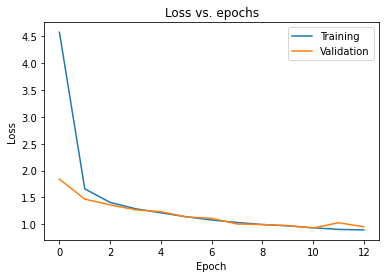

In [26]:
#Loss vs Epoch MLP model

plt.plot(MLP_history.history['loss'])
plt.plot(MLP_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [27]:
#Run the trained model on test data

MLP_model.evaluate(gs_test_images,test_labels,verbose=2)

814/814 - 1s - loss: 1.0549 - accuracy: 0.6919


[1.0548843145370483, 0.6918792128562927]

## 3. CNN neural network classifier

In [28]:
#Define CNN model

def get_new_CNN_model(input_shape, rate):
    
    model = Sequential([
        Conv2D(8, (3,3), activation = "relu", input_shape = input_shape, padding = "SAME"),
        Conv2D(4, (3,3), activation = "relu", padding = "SAME"),
        MaxPooling2D((8,8)),
        Flatten(),
        Dense(16, activation = "relu"),
        Dropout(rate),
        Dense(16, activation = "relu"),
        BatchNormalization(),
        Dense(10, activation = "softmax")
    ])
    
    return model

In [29]:
CNN_model = get_new_CNN_model(gs_train_images[0].shape, 0.1)

In [30]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         292       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 4)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)               

In [31]:
#Compile the model

CNN_model.compile(optimizer = "adam", 
                  loss = "sparse_categorical_crossentropy", 
                  metrics = ["accuracy"])

In [32]:
#Callback no 1

#Model Checkpoint Callback

checkpoint_best_only_path_CNN = "checkpoints_best_only_CNN/checkpoint"
checkpoint_best_only_CNN = ModelCheckpoint(filepath = checkpoint_best_only_path_CNN,
                                       save_weights_only = True, 
                                       monitor = "val_accuracy", 
                                       save_freq = "epoch", 
                                       save_best_only = True,
                                       verbose = 0)

In [33]:
#Callback no 2

#Early Stopping callback

early_stopping_CNN = EarlyStopping(monitor = "val_accuracy", 
                               patience=2, 
                               mode="max")

In [34]:
CNN_history = CNN_model.fit(gs_train_images, 
                            train_labels, 
                            epochs=30, 
                            validation_split=0.15, 
                            batch_size=64,
                            callbacks=[checkpoint_best_only_CNN, early_stopping_CNN])

Epoch 1/30
973/973 [==============================] - 35s 6ms/step - loss: 2.2635 - accuracy: 0.1769 - val_loss: 2.1746 - val_accuracy: 0.2252
Epoch 2/30
973/973 [==============================] - 5s 5ms/step - loss: 2.0580 - accuracy: 0.2580 - val_loss: 1.8732 - val_accuracy: 0.3415
Epoch 3/30
973/973 [==============================] - 6s 6ms/step - loss: 1.7289 - accuracy: 0.3860 - val_loss: 1.5717 - val_accuracy: 0.4596
Epoch 4/30
973/973 [==============================] - 6s 6ms/step - loss: 1.5287 - accuracy: 0.4744 - val_loss: 1.3891 - val_accuracy: 0.5378
Epoch 5/30
973/973 [==============================] - 6s 6ms/step - loss: 1.3717 - accuracy: 0.5415 - val_loss: 1.2113 - val_accuracy: 0.5981
Epoch 6/30
973/973 [==============================] - 6s 6ms/step - loss: 1.2686 - accuracy: 0.5807 - val_loss: 1.1617 - val_accuracy: 0.6252
Epoch 7/30
973/973 [==============================] - 6s 6ms/step - loss: 1.2008 - accuracy: 0.6038 - val_loss: 1.1213 - val_accuracy: 0.6466
Epoch

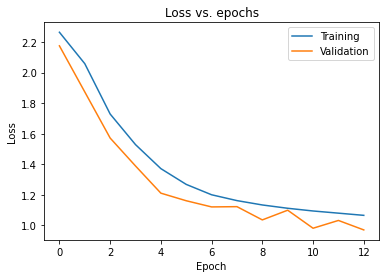

In [35]:
#Loss vs Epoch

plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [36]:
#Run the model on test data


CNN_model.evaluate(gs_test_images,test_labels,verbose=2)

814/814 - 2s - loss: 0.9820 - accuracy: 0.6895


[0.9820367693901062, 0.6895359754562378]

In [44]:
# MLP model and CNN model comparison

#___________________________________
# MLP model 

# Parameters: 697,930
# Training epochs: 13
# Test set accuracy: 0.69

#___________________________________
# CNN model

# Parameters: 1,918
# Training epochs: 13
# Test set accuracy: 0.69

#___________________________________

# For similar performance, the CNN model uses lesser parameters than the MLP model.



## 4. Get model predictions

In [37]:
MLP_model.load_weights("checkpoints_best_only_MLP/checkpoint")

In [38]:
CNN_model.load_weights("checkpoints_best_only_CNN/checkpoint")

In [39]:
#Randomly select an image from the test set

seed_2 = random.sample(range(0,m_test), 1)

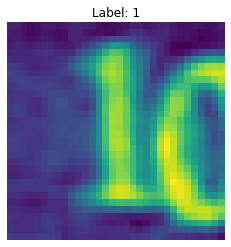

In [40]:
#Image 1

image = gs_test_images[seed_2[0],:,:,0]
plt.imshow(image)
plt.axis('off')
plt.title(f'Label: {test_labels[seed_2[0],0]}')
plt.show()

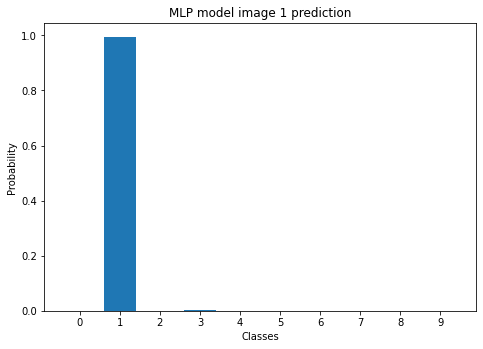

In [41]:
#MLP model prediction for image 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['0','1', '2', '3', '4', '5','6','7','8','9']
prediction = np.squeeze(np.asarray(MLP_model.predict(gs_test_images[None,seed_2[0],:,:,:])))
ax.bar(labels,prediction)
plt.title('MLP model image 1 prediction')
plt.ylabel('Probability')
plt.xlabel('Classes')
plt.show()

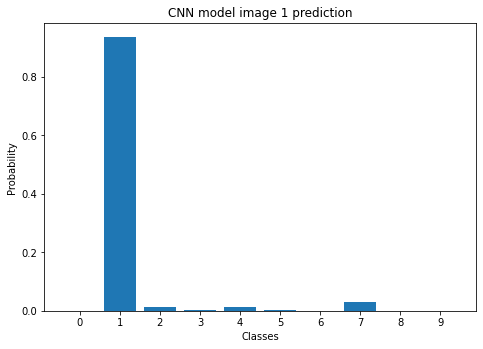

In [43]:
#CNN model prediction for image 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['0','1', '2', '3', '4', '5','6','7','8','9']
prediction = np.squeeze(np.asarray(CNN_model.predict(gs_test_images[None,seed_2[0],:,:,:])))
ax.bar(labels,prediction)
plt.title('CNN model image 1 prediction')
plt.ylabel('Probability')
plt.xlabel('Classes')
plt.show()